In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [3]:
def split_sequence(sequence, n_steps):
    list_subsequences = []
    empty_subsequence = [np.nan] * n_steps
    # Fill the initial subsequences with nan
    for i in range(min(n_steps, len(sequence))):
        list_subsequences.append(empty_subsequence)
    if len(sequence) <= n_steps:
        return list_subsequences
    # Fill the remaining subsequences
    for i in range(n_steps, len(sequence)):
        subsequence = sequence[i - n_steps:i]
        list_subsequences.append(subsequence)
    return list_subsequences

In [4]:
n_steps = 20
columns = ['t_minus_{}'.format(n_steps - i) for i in range(n_steps)]

In [5]:
df = pd.read_pickle(r"D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\full_market_data_final.pkl")
df = df[['asset_identifier', 'date', 'close', 'universe', 'min_fin_volume']]
df.loc[:, 'ret'] = df.groupby('asset_identifier')['close'].pct_change()

In [6]:
%%time
list_df = []
for asset, data in df.groupby('asset_identifier'):
    ret_shift_as_seq = split_sequence(data.loc[:, 'ret'].to_list(), n_steps)
    ret_shift_as_seq = pd.DataFrame(ret_shift_as_seq, index = data.index, columns = columns)
    data = data.join(ret_shift_as_seq)
    list_df.append(data)

Wall time: 2.09 s


In [7]:
df = pd.concat(list_df)

In [8]:
df.loc[:, 'target'] = df.groupby('asset_identifier')['ret'].shift(-1)

In [9]:
split_date = '2007-12-31'

In [10]:
data_train = df.query("date < @split_date & universe")[['asset_identifier', 'date'] + columns  + ['target']].dropna()
data_test = df.query("date > @split_date & universe")[['asset_identifier', 'date'] + columns  + ['target']].dropna()

In [11]:
X_train = data_train[columns].values
y_train = data_train['target'].values

X_test = data_test[columns].values
y_test = data_test['target'].values

In [12]:
n_features = 1
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [13]:
X_train = X_train.reshape((-1, X_train.shape[1], n_features))
X_test = X_test.reshape((-1, X_test.shape[1], n_features))

In [14]:
%%time
history = model.fit(X_train, y_train, epochs=200, verbose=1, batch_size = 100_000)

Epoch 1/200
2/2 [==============================] - 9s 4s/step - loss: 8.1242e-04
Epoch 2/200
2/2 [==============================] - 8s 4s/step - loss: 8.1255e-04
Epoch 3/200
2/2 [==============================] - 8s 4s/step - loss: 7.9975e-04
Epoch 4/200
2/2 [==============================] - 8s 4s/step - loss: 7.9784e-04
Epoch 5/200
2/2 [==============================] - 8s 4s/step - loss: 8.0081e-04
Epoch 6/200
2/2 [==============================] - 8s 4s/step - loss: 8.0856e-04
Epoch 7/200
2/2 [==============================] - 8s 4s/step - loss: 7.9671e-04
Epoch 8/200
2/2 [==============================] - 8s 4s/step - loss: 7.9508e-04
Epoch 9/200
2/2 [==============================] - 8s 4s/step - loss: 8.0357e-04
Epoch 10/200
2/2 [==============================] - 8s 4s/step - loss: 7.9951e-04
Epoch 11/200
2/2 [==============================] - 9s 4s/step - loss: 7.9629e-04
Epoch 12/200
2/2 [==============================] - 9s 4s/step - loss: 7.9724e-04
Epoch 13/200
2/2 [=======

In [15]:
history.history.keys()

dict_keys(['loss'])

In [16]:
history.history.keys()

dict_keys(['loss'])

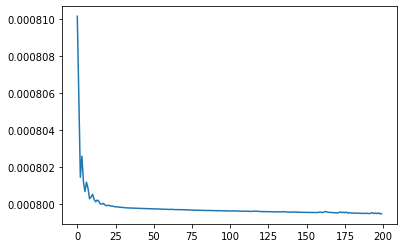

In [17]:
plt.plot(history.history['loss'])

In [18]:
yhat_train = model.predict(X_train)

In [19]:
np.corrcoef(y_train, yhat_train.reshape(-1))

array([[1.        , 0.03686094],
       [0.03686094, 1.        ]])

In [20]:
yhat_test = model.predict(X_test)
np.corrcoef(y_test, yhat_test.reshape(-1))

array([[1.        , 0.02036362],
       [0.02036362, 1.        ]])

In [21]:
yhat_test

array([[0.00089322],
       [0.00126115],
       [0.00129631],
       ...,
       [0.0003476 ],
       [0.00110105],
       [0.00189468]], dtype=float32)

In [22]:
data_test.loc[:, 'yhat'] = yhat_test.reshape(-1)

<AxesSubplot:>

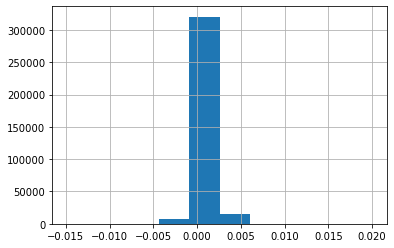

In [23]:
data_test.loc[:, 'yhat'].clip(-0.02, 0.02).hist()

<AxesSubplot:>

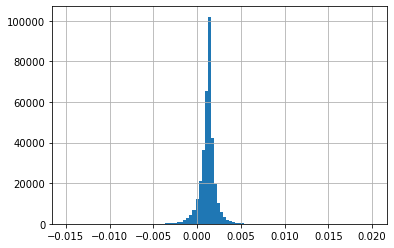

In [24]:
data_test.loc[:, 'yhat'].clip(-0.02, 0.02).hist(bins = 100)

In [39]:
data_test.columns

Index(['asset_identifier', 'date', 't_minus_20', 't_minus_19', 't_minus_18',
       't_minus_17', 't_minus_16', 't_minus_15', 't_minus_14', 't_minus_13',
       't_minus_12', 't_minus_11', 't_minus_10', 't_minus_9', 't_minus_8',
       't_minus_7', 't_minus_6', 't_minus_5', 't_minus_4', 't_minus_3',
       't_minus_2', 't_minus_1', 'target', 'yhat'],
      dtype='object')

In [51]:
data_test.loc[:, 'choose1'] = data_test.groupby('date')['yhat'].apply(lambda x: x.rank(ascending = False) < 20)
data_test.loc[:, 'choose2'] = data_test.groupby('date')['yhat'].apply(lambda x: (x.rank(ascending = False) >= 20) & (x.rank(ascending = False) < 40))

<AxesSubplot:xlabel='date'>

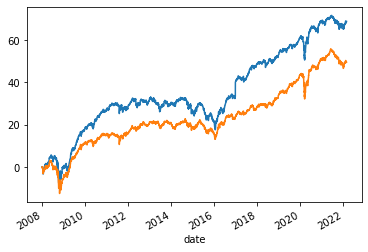

In [52]:
data_test.eval("PnL = choose1 * target").groupby('date')['PnL'].sum().cumsum().plot()
data_test.eval("PnL = choose2 * target").groupby('date')['PnL'].sum().cumsum().plot()

<AxesSubplot:xlabel='date'>

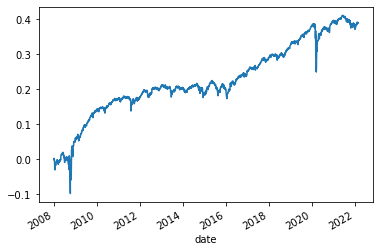

In [25]:
data_test.eval("PnL = yhat * target").groupby('date')['PnL'].sum().cumsum().plot()

<AxesSubplot:xlabel='date'>

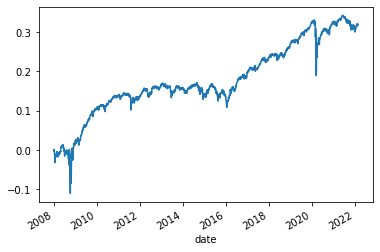

In [37]:
data_test.query("yhat > 0").eval("PnL = yhat * target").groupby('date')['PnL'].sum().cumsum().plot()

<AxesSubplot:xlabel='date'>

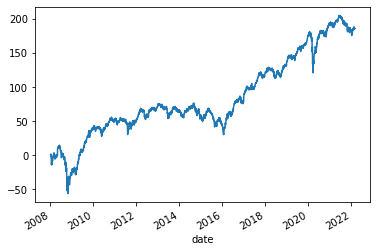

In [30]:
data_test.query("yhat > 0").eval("PnL = target").groupby('date')['PnL'].sum().cumsum().plot()

In [26]:
data_test.to_pickle(r"D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\df_test_mestrado.pkl")